In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json

In [2]:
curr_dir=os.getcwd()
grandparent_dir = os.path.abspath(os.path.join(curr_dir, os.pardir,os.pardir))
print(grandparent_dir)
sys.path.append(os.path.join(grandparent_dir))
sys.path.append(os.path.join(grandparent_dir, 'liset_tk'))
print(sys.path)
from liset_tk import liset_tk

from liset_aux import ripples_std, middle


c:\Users\Pc\Documents\Tese\LAVA_SNN_ripples
['c:\\nrn\\lib\\python', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\python39.zip', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\DLLs', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples', '', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\win32\\lib', 'c:\\Users\\Pc\\anaconda3\\envs\\lava_snn_ripples\\lib\\site-packages\\Pythonwin', 'c:\\Users\\Pc\\Documents\\Tese\\LAVA_SNN_ripples', 'c:\\Users\\Pc\\Documents\\Tese\\LAVA_SNN_ripples\\liset_tk']



In [ ]:
# parent = r"C:\__NeuroSpark_Liset_Dataset__\neurospark_mat\CNN_TRAINING_SESSIONS" # Modify this to your data path folder
parent=r"E:\neurospark_mat\CNN_TRAINING_SESSIONS"


bandpass=[100,250]
downsampled_fs = 1000 # Downsampled frequency
liset_freq=False
WINDOW_SHIFT=int(119*downsampled_fs/1000)
WINDOW_SIZE=int(180*downsampled_fs/1000)
time_max=600
window_size=0.05
sample_ratio=0.25
scaling_factor=1
refractory=0

In [4]:
dt=1  # Time step in milliseconds (1 ms)


RIPPLE_DETECTION_OFFSET = [18, 45, 31, 20] # it's calculated as 4.5 periods of the ripple wavelet - for 100 Hz and 250 Hz as the limit frequencies
# The Windows for HFO detection are based on the MAX DETECTION OFFSET

#TODO - Why are these values? Can I tune them in a better way?
RIPPLE_CONFIDENCE_WINDOW = int(round(RIPPLE_DETECTION_OFFSET[1] * 1.8)) 

# in timesteps (ms) - Max time from the Insertion Timing to the GT annotation
MAX_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[1]   # in timesteps (ms)

MEAN_DETECTION_OFFSET = RIPPLE_DETECTION_OFFSET[2]   # in timesteps (ms)

WINDOW_SIZE = int(RIPPLE_DETECTION_OFFSET[1]*4)   # in timesteps (ms) - The size of the window to slice the input data

# unit: timesteps (ms) - The number of steps that 2 consecutive windows must overlap to not lose any relevant CBs
# INTERSECT_WINDOW_LEN = int(MAX_DETECTION_OFFSET)
std, mean = ripples_std(parent) # 61 ms # in seconds
INTERSECT_WINDOW_LEN=int((std+mean)*1000) # in timesteps (ms) - The size of the intersection window to slice the input data

# unit: timesteps (ms) - The number of steps that the window must shift to get the next window
WINDOW_SHIFT = int(WINDOW_SIZE - INTERSECT_WINDOW_LEN)

# unit: timesteps (ms) - The time window after the GT annotation where the network should predict the burst (GT_time, GT_time + PRED_CAUSALITY_WINDOW)
# This is needed to give the network some extra time steps to increase the membrane potential and spike
PRED_CAUSALITY_WINDOW = int(5)     # Giving PRED_CAUSALITY_WINDOW ms for the network to update its inner state and spike   

# unit: timesteps (ms) - The time window around the GT annotation where the network should predict the burst (GT_time - PRED_GT_TOLERANCE, GT_time + PRED_GT_TOLERANCE)
PRED_GT_TOLERANCE = int(RIPPLE_DETECTION_OFFSET[3])  # in timesteps (ms)
print(f"WINDOW_SIZE: {WINDOW_SIZE}")
print(f"INTERSECT_WINDOW_LEN: {INTERSECT_WINDOW_LEN} (MEAN+STD)")
print(f"WINDOW_SHIFT: {WINDOW_SHIFT}")
print(f"MEAN DETECTION OFFSET: {MEAN_DETECTION_OFFSET}")
print(f"PRED_GT_TOLERANCE: {PRED_GT_TOLERANCE}")
print(f"PRED_CAUSALITY_WINDOW: {PRED_CAUSALITY_WINDOW}")

WINDOW_SIZE: 180
INTERSECT_WINDOW_LEN: 61 (MEAN+STD)
WINDOW_SHIFT: 119
MEAN DETECTION OFFSET: 31
PRED_GT_TOLERANCE: 20
PRED_CAUSALITY_WINDOW: 5


In [5]:
config = {
    "bandpass": bandpass,
    "downsampled_fs": downsampled_fs,
    "time_max": time_max,
    "window_size": window_size,
    "sample_ratio": sample_ratio,
    "scaling_factor": scaling_factor,
    "refractory": refractory,
    "dt":dt,
    "WINDOW_SHIFT": WINDOW_SHIFT,
    "WINDOW_SIZE": WINDOW_SIZE,
    "INTERSECT_WINDOW_LEN": INTERSECT_WINDOW_LEN,
    "RIPPLE_DETECTION_OFFSET": RIPPLE_DETECTION_OFFSET,
    "PRED_CAUSALITY_WINDOW": PRED_CAUSALITY_WINDOW,
}

In [6]:
from signal_aid import most_active_channel, bandpass_filter


In [ ]:
load=False


from extract_Nripples.utils_encoding import *
# Only run this block if first time
if 'windowed_input_dataa' not in locals():
    if load:
        windowed_path=os.path.join(curr_dir,"windowed_data")
        windowed_input_data = np.load(os.path.join(windowed_path,"windowed_input_data.npy"))
        windowed_gt = np.load(os.path.join(windowed_path,"windowed_gt.npy"))
        filtered_windows=np.load(os.path.join(windowed_path,"filtered_windows.npy"))
    else:
        # Split the Input Data and Ground Truth into Windows
        windowed_input_data = []    # Input Data Windows
        windowed_gt = []        # Ground Truth Windows (spike time if HFO, -1 if no HFO)
        filtered_windows=[] 
        total_windows_count = 0
        skipped_hfo_count = 0   # Counts the nº of skipped HFOs due to no input activations
        total_hfos=0
        # curr_ripple_times = ripples_concat[curr_ripple_id]    # Get the GT times for the current sEEG source

        # LOAD THE DATA
        # Iterate over the datasets
        for dataset in os.listdir(parent):
            config[str(dataset)]={}
            dataset_path = os.path.join(parent, dataset)
            liset= liset_tk(dataset_path, shank=3, downsample=liset_freq, verbose=False)

            ripples=np.array(liset.ripples_GT)
            spikified=np.zeros((liset.data.shape[0], liset.data.shape[1], 2))
            filtered=np.zeros((liset.data.shape[0], liset.data.shape[1]))
            thresholds = []

            print("data shape: ", liset.data.shape)
            print("ripples shape: ", ripples.shape)
            # print("Head of data_concat: ", data[:10][:])
            # print("Head of ripples_concat: ", ripples[:10])
            ripples = ripples[np.argsort(ripples[:, 0])]
            # print(ripples[:10][:])
            
            for channel in range(liset.data.shape[1]):
                channel_signal = liset.data[:time_max*downsampled_fs, channel]
                filtered_signal=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                thresholds.append(round(calculate_threshold(filtered_signal,downsampled_fs,window_size,sample_ratio,scaling_factor),4))

                if thresholds[channel] > 0.1:
                    channel_signal = liset.data[:, channel]
                    curr_ripple_id = 0     # Keep track of the current GT event index since it is monotonically increasing the timestep
                    filtered_liset=bandpass_filter(channel_signal, bandpass=bandpass, fs=liset.fs)
                    spikified[:, channel, :]=up_down_channel(filtered_liset,thresholds[channel],liset.fs,refractory)
                    
                    for i in range(0, liset.data.shape[0], WINDOW_SHIFT):
                        left, right = i, i+WINDOW_SIZE
                        # Get the current input window
                        curr_window = spikified[left:right, channel, :]
                        filtered_window = filtered_liset[left:right]
                        
                        # Increment the total windows count
                        total_windows_count += 1
                        # Check if the current window is smaller than the expected size
                        if curr_window.shape[0] < WINDOW_SIZE:
                            # If the current window is smaller than the expected size, break the loop
                            print(f"[WARNING] Current window [{left}, {right}] is smaller than the expected size. Breaking the loop...")
                            break

                        # OPTIMIZATION STEP: Skip windows with no activations - The gradient will be zero 
                        if np.sum(curr_window) == 0:
                            # print(f"Window [{left}:{right}] has no Input activations. Skipping...")
                            cur_gt_time=[-1, -1]    # Default value for Spike Time (no HFO)
                            if curr_ripple_id < ripples.shape[0]:
                                cur_gt_time = ripples[curr_ripple_id]  
                            if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                                if cur_gt_time[1] <= right:
                                    print(f"[WARNING] Window [{left}:{right}] has a GT event at {cur_gt_time} and NO Input activations. Skipping...")
                                    # Update the curr_gt_idx to the next GT event
                                    skipped_hfo_count += 1
                                curr_ripple_id += 1
                            continue   
                        
                        '''
                        Check if there is a GT event in the current window
                        '''

                        curr_gt = -1    # Default value for Spike Time (no HFO)
                        
                        # Check if the current GT event is within the current window
                        while curr_ripple_id<ripples.shape[0]-1 and ripples[curr_ripple_id][1] < left:
                            # Ripple ends before the window starts → skip it
                            curr_ripple_id += 1
                        
                        if curr_ripple_id >= ripples.shape[0]:
                            curr_ripple_id=ripples.shape[0]-1
                    
                        cur_gt_time = ripples[curr_ripple_id]      
                        if (cur_gt_time[1] >= left) and (cur_gt_time[0] <= right):
                            '''
                                Check if the current window overlaps with the current GT event
                                The Network may spike in the interval [GT_time[0], GT_time[0] + MEAN_HFO_DURATION + PRED_GT_TOLERANCE]
                                However, we are using an upper limit for the HFO Duration of WINDOW_SIZE.
                                This way, the Ground Truth Timestamps will be clamped uppwards by WINDOW_SIZE - MAX_HFO_DURATION + MEAN_HFO_DURATION
                            '''
                            if cur_gt_time[1] <= right and cur_gt_time[0]>=left: # If the GT event is completely within the current window
                                '''The Network should predict the HFO -> Calculate the spike time
                                Let's assume the network should spike at the end of the relevant event. We have no way of knowing
                                the exact end time, so we use the mean duration of the event to calculate the spike time.
                                '''
                                avg_spike_time = cur_gt_time[0] +  MEAN_DETECTION_OFFSET # The network should spike at the end of the relevant event
                                
                                # Subtract the left offset to get the spike time in the current window
                                relative_spike_time = avg_spike_time - left
                                if relative_spike_time > WINDOW_SIZE:
                                    # If the spike time is greater than the window size, we want to skip the window
                                    print(f"[WARNING] Spike time {relative_spike_time} is greater than the window size {WINDOW_SIZE}. Adjusting...")
                                    relative_spike_time= cur_gt_time[1]-left

                                curr_gt = relative_spike_time   # Update the curr_gt value

                                # Update the curr_gt_idx to the next GT event
                                curr_ripple_id += 1
                                
                            elif cur_gt_time[1] > right or cur_gt_time[0] < left:
                                continue
                                # If the GT event is not completely within the current window, we want to skip the window
                        
                        # Append the current window    
                        windowed_input_data.append(curr_window)            
                        # Append the current GT Spike Time to the windowed GT
                        windowed_gt.append(curr_gt)
                        filtered_windows.append(filtered_window)
                    total_hfos+=ripples.shape[0]
                else:
                    print(f"[WARNING] Channel {channel} has a very low threshold. Skipping...")
            config[str(dataset)]["thresholds"]=thresholds
        # Convert to numpy array
        filtered_windows=np.array(filtered_windows, dtype=np.float32)
        windowed_input_data = np.array(windowed_input_data)
        windowed_gt = np.array(windowed_gt, dtype=np.float32)
        removed_windows = total_windows_count - windowed_input_data.shape[0]
        print(f"Removed {removed_windows}/{total_windows_count} ({round((removed_windows / total_windows_count)*100, 2)}%) windows with no input activations")
        print(f"Skipped {skipped_hfo_count} HFOs due to no input activations")
        print(f"Total HFOs (theoretical): {total_hfos}")
else:
    print("Code Block already run. Skipping...")

print("Windowed Input Data Shape: ", windowed_input_data.shape)
print("Windowed GT Shape: ", windowed_gt.shape)
print("Filtered Windows Shape: ", filtered_windows.shape)



data shape:  (2398857, 8)
ripples shape:  (1309, 2)
[WARNING] Window [17850:18030] has a GT event at [17918 17946] and NO Input activations. Skipping...
[WARNING] Window [75446:75626] has a GT event at [75491 75536] and NO Input activations. Skipping...
[WARNING] Spike time 183 is greater than the window size 180. Adjusting...
[WARNING] Window [292978:293158] has a GT event at [293008 293056] and NO Input activations. Skipping...
[WARNING] Window [340340:340520] has a GT event at [340361 340405] and NO Input activations. Skipping...
[WARNING] Window [348194:348374] has a GT event at [348219 348281] and NO Input activations. Skipping...
[WARNING] Window [373422:373602] has a GT event at [373502 373542] and NO Input activations. Skipping...
[WARNING] Window [424949:425129] has a GT event at [425024 425084] and NO Input activations. Skipping...
[WARNING] Window [520863:521043] has a GT event at [520946 520979] and NO Input activations. Skipping...
[WARNING] Window [551089:551269] has a GT

In [8]:
up_spikes_per_window = np.sum(windowed_input_data[:, :, 0], axis=1)    # Sum along time axis
down_spikes_per_window = np.sum(windowed_input_data[:, :, 1], axis=1)  # Sum along time axis
print("Up Spikes Total:",np.sum(up_spikes_per_window))
print("Down Spikes Total:",np.sum(down_spikes_per_window))

Up Spikes Total: 1250232.0
Down Spikes Total: 1256750.0


In [8]:
# See GT Class Distribution
# Set print options to see more elements
np.set_printoptions(linewidth=100, threshold=50, edgeitems=20)
print(f"Ground Truth Class Distribution: {np.unique(windowed_gt, return_counts=True)}")



GT_HFO_MASK = windowed_gt >= 0
# print(windowed_gt[0:1000])
# Define the number of windows with an HFO
num_hfo_windows = np.sum(GT_HFO_MASK)
print(f"Number of windows with an HFO: {num_hfo_windows}")
print(f"Percentage of windows with an HFO: {num_hfo_windows / windowed_gt.shape[0] * 100:.2f}%")


Ground Truth Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([141002,     21,     25,      6,     27,      5,     18,     14,      5,     57,     36,
           18,     29,     23,     23,     49,     56,     46,     28,     66, ...,     44,     51,
           87,     57,     45,     29,     39,     50,     39,     43,     53,     53,     21,
           33,      8,     10,     28,     24,     22,      7], dtype=int64))
Number of windows with an HFO: 9825
Percentage of windows with an HFO: 6.51%


In [9]:
# Find the indices to sort the input data by the nº of UP/DN spikes (descending order)
sorted_indices = np.argsort(
    -(np.sum(windowed_input_data[:, :, 0], axis=1) + np.sum(windowed_input_data[:, :, 1], axis=1)), 
)
sorted_spikes = windowed_input_data[sorted_indices]
sorted_gt= windowed_gt[sorted_indices]
sorted_filtered_windows=filtered_windows[sorted_indices]
sorted_up_spikes_per_window = np.sum(sorted_spikes[:, :, 0], axis=1)    # Sum along time axis
sorted_down_spikes_per_window = np.sum(sorted_spikes[:, :, 1], axis=1)  # Sum along time axis
print(f"sorted_indices: {sorted_indices}")
print(f"Sorted_data: {sorted_spikes.shape} | Sorted_gt: {sorted_gt.shape}| Sorted_filtered_windows: {sorted_filtered_windows.shape}")
print(f"Sorted_gt preview: {sorted_gt[:10]}")
print(f"GT first window: {sorted_gt[0]} | GT last window: {sorted_gt[-1]}")

sorted_indices: [ 14146  16258  14696  14136  14950  61983  16622  12102  14068  60723  16075  13115  59945  17096
   6192  16221  62777  25302  13767  14151 ...  83308  76002   4608  19735 111415  44636 119538
 143450 119547  33563  33566 145635  28388  28383  44990  20571  75933  33511  28409  69568]
Sorted_data: (150827, 180, 2) | Sorted_gt: (150827,)| Sorted_filtered_windows: (150827, 180)
Sorted_gt preview: [-1. -1. -1. -1. -1. 88. -1. -1. -1. 58.]
GT first window: -1.0 | GT last window: -1.0


In [23]:
start, end= 90000,100000
sorted_gt_distribution=sorted_gt[start:end]

non_neg_indices = np.where(sorted_gt_distribution != -1)[0]
absolute_indices = start + non_neg_indices

print(f"Sorted GT Distribution: {np.unique(sorted_gt_distribution, return_counts=True)}")
print(f"Sorted_gt preview: {sorted_gt_distribution[:10]}")

print(absolute_indices[-1])

Sorted GT Distribution: (array([ -1.,  31.,  32.,  33.,  37.,  40.,  41.,  42.,  43.,  44.,  45.,  47.,  50.,  54.,  55.,
        56.,  57.,  59.,  60.,  61., ..., 144., 145., 146., 147., 149., 150., 151., 152., 154.,
       155., 156., 159., 160., 162., 163., 167., 168., 170., 176., 177.], dtype=float32), array([9772,    1,    1,    1,    1,    2,    1,    2,    2,    2,    1,    1,    3,    1,    1,
          1,    2,    3,    2,    2, ...,    3,    1,    1,    1,    3,    2,    1,    1,    3,
          1,    3,    2,    1,    1,    6,    2,    2,    2,    1,    2], dtype=int64))
Sorted_gt preview: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
99998


180


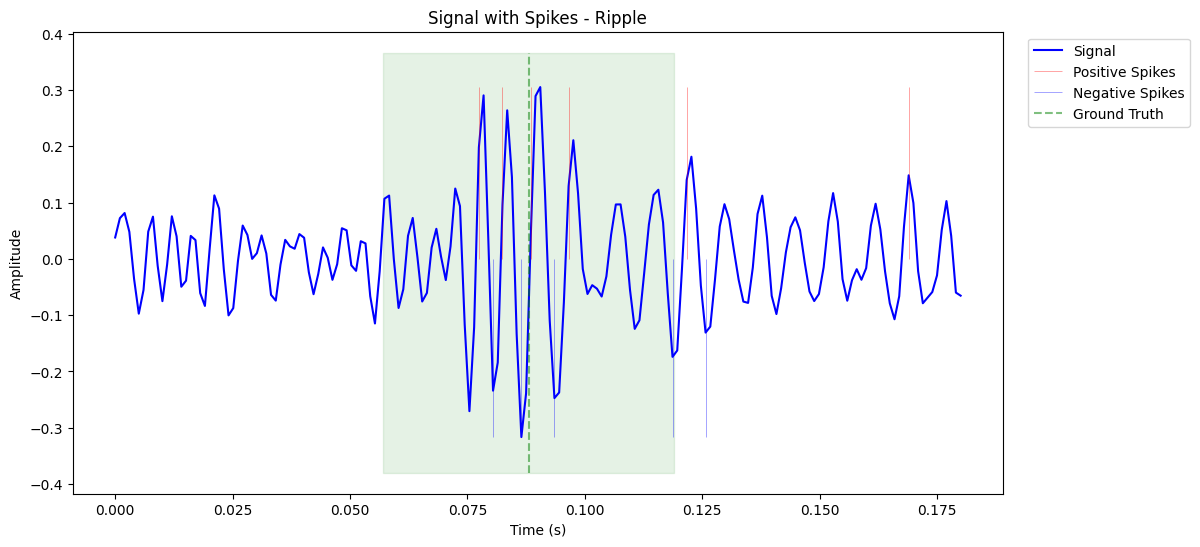

Total Spikes: 11.0
Up Spikes: 6.0
Down Spikes: 5.0


In [25]:
from snnTorch.utils.util import window_plot
window=absolute_indices[0]
plot_spikes=sorted_spikes[window,:,:]
plot_filtered_window=sorted_filtered_windows[window,:]
plot_gt=sorted_gt[window]
window_plot(plot_filtered_window,plot_spikes, plot_gt,downsampled_fs=downsampled_fs,detection_window=RIPPLE_DETECTION_OFFSET)
up_spikes_window = np.sum(plot_spikes[:, 0])    # Sum along time axis
down_spikes_window = np.sum(plot_spikes[:, 1])  # Sum along time axis
print("Total Spikes:",up_spikes_window+down_spikes_window)
print("Up Spikes:",sorted_up_spikes_per_window[window])
print("Down Spikes:",sorted_down_spikes_per_window[window])

In [12]:
is_hfo = windowed_gt >= 0
hfo_windows = windowed_input_data[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = windowed_input_data[~is_hfo]  # shape: (N_nonHFO, 180, 2)

In [14]:
# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts = hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts = np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts


In [15]:
def get_isi(spike_train):
    times_up = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_down = np.where(spike_train[:,0])[0]  # spike times (e.g., indices)
    times_total= np.concatenate((times_up, times_down))
    times_total.sort()  # sort the spike times
    if len(times_total) < 2:
        return np.array([])  # no ISI to compute
    return np.diff(times_total)

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


## After Undersampling Non-Ripples

In [33]:
from snnTorch.utils.training import undersample_majority, oversample_minority
intermediate_input, intermediate_gt = windowed_input_data, windowed_gt  # Default: No Balancing
balance=True
if balance:
    intermediate_input, intermediate_gt = undersample_majority(windowed_input_data, windowed_gt, GT_HFO_MASK)  

# Print the number of samples in each class
print(f"Intermediate GT Class Distribution: {np.unique(intermediate_gt, return_counts=True)}")
print(f"Intermediate Window Input Data Shape: {intermediate_input.shape}")


Intermediate GT Class Distribution: (array([ -1.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49., ..., 161., 162., 163., 164., 165., 166., 167., 168., 169.,
       170., 171., 172., 173., 174., 175., 176., 177., 178., 179., 180.], dtype=float32), array([9825,   21,   25,    6,   27,    5,   18,   14,    5,   57,   36,   18,   29,   23,   23,
         49,   56,   46,   28,   66, ...,   44,   51,   87,   57,   45,   29,   39,   50,   39,
         43,   53,   53,   21,   33,    8,   10,   28,   24,   22,    7], dtype=int64))
Intermediate Window Input Data Shape: (19650, 180, 2)


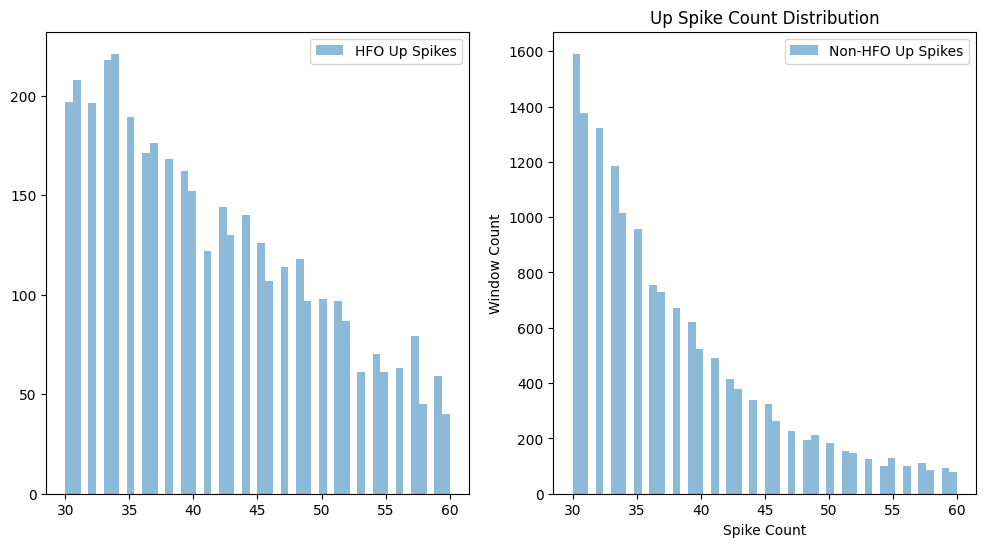

In [17]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(total_hfo_counts,range=(30,60),bins=50, alpha=0.5, label='HFO Up Spikes')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(total_nonhfo_counts, bins=50,range=(30,60), alpha=0.5, label='Non-HFO Up Spikes')
plt.legend()
plt.title('Up Spike Count Distribution')
plt.xlabel('Spike Count')
plt.ylabel('Window Count')
plt.show()

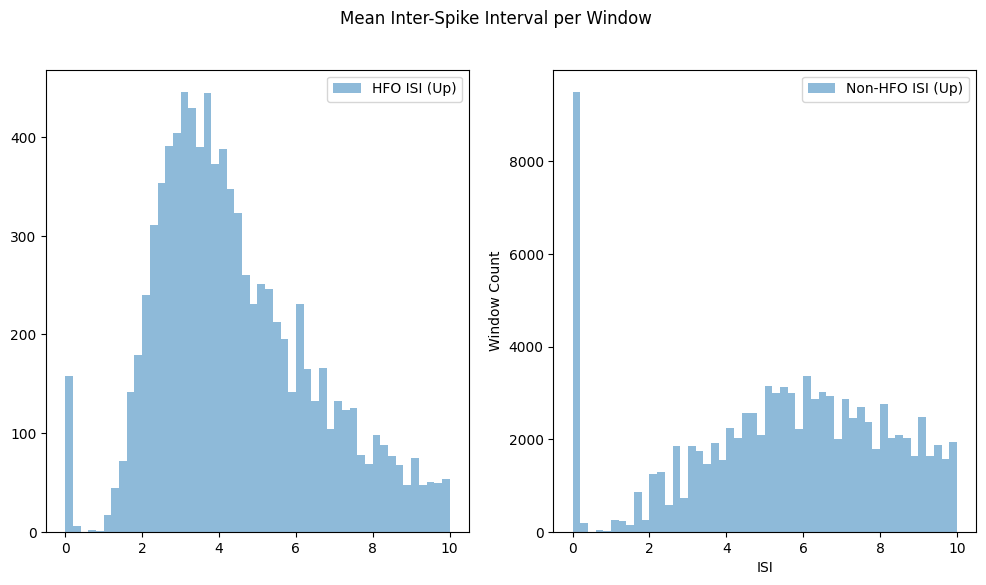

In [18]:
plt.subplots(1,2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(hfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='HFO ISI (Up)')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nonhfo_up_isi_mean,range=(0,10), bins=50, alpha=0.5, label='Non-HFO ISI (Up)')
plt.legend()
plt.suptitle('Mean Inter-Spike Interval per Window')
plt.xlabel('ISI')
plt.ylabel('Window Count')
plt.show()

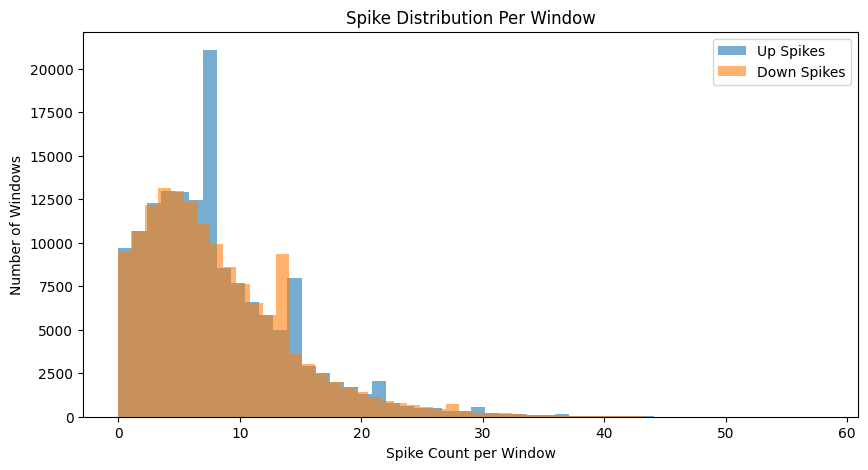

In [19]:

# Histogram of up/down spike counts
plt.figure(figsize=(10,5))
plt.hist(up_spikes_per_window, bins=50, alpha=0.6, label='Up Spikes')
plt.hist(down_spikes_per_window, bins=50, alpha=0.6, label='Down Spikes')
plt.xlabel('Spike Count per Window')
plt.ylabel('Number of Windows')
plt.title('Spike Distribution Per Window')
plt.legend()
plt.show()

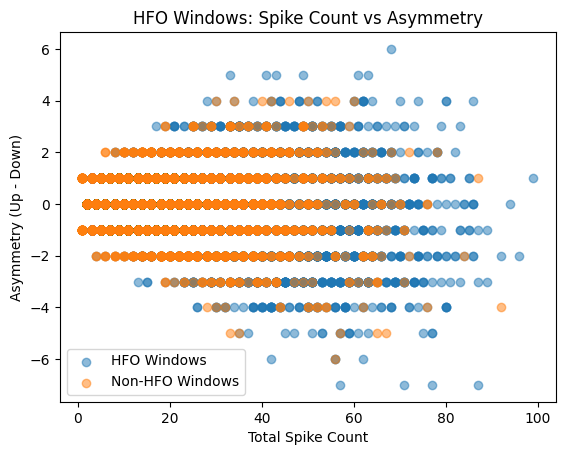

In [34]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Asymmetry')
plt.legend()
plt.show()

In [35]:
is_hfo= intermediate_gt >= 0
hfo_windows = intermediate_input[is_hfo]       # shape: (N_HFO, 180, 2)
non_hfo_windows = intermediate_input[~is_hfo]  # shape: (N_nonHFO, 180, 2)

# Sum over time axis
hfo_up_counts = np.sum(hfo_windows[:, :, 0], axis=1)
hfo_down_counts = np.sum(hfo_windows[:, :, 1], axis=1)
total_hfo_counts= hfo_up_counts + hfo_down_counts
nonhfo_up_counts = np.sum(non_hfo_windows[:, :, 0], axis=1)
nonhfo_down_counts= np.sum(non_hfo_windows[:, :,1], axis=1)
total_nonhfo_counts = nonhfo_up_counts + nonhfo_down_counts

average_hfo_up_counts = np.mean(hfo_up_counts)
average_hfo_down_counts = np.mean(hfo_down_counts)
average_total_hfo_counts = np.mean(total_hfo_counts)
average_nonhfo_up_counts = np.mean(nonhfo_up_counts)
average_nonhfo_down_counts = np.mean(nonhfo_down_counts)
average_total_nonhfo_counts = np.mean(total_nonhfo_counts)
print(f"Average HFO Up Counts: {average_hfo_up_counts}")
print(f"Average HFO Down Counts: {average_hfo_down_counts}")
print(f"Average Total HFO Counts: {average_total_hfo_counts}")
print(f"Average Non-HFO Up Counts: {average_nonhfo_up_counts}")
print(f"Average Non-HFO Down Counts: {average_nonhfo_down_counts}")
print(f"Average Total Non-HFO Counts: {average_total_nonhfo_counts}")

# Example for all HFO windows (up channel):
hfo_up_isis = [get_isi(window[:, :]) for window in hfo_windows]
nonhfo_up_isis = [get_isi(window[:, :]) for window in non_hfo_windows]

hfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in hfo_up_isis])
nonhfo_up_isi_mean = np.array([np.mean(isi) if len(isi) > 0 else 0 for isi in nonhfo_up_isis])


Average HFO Up Counts: 14.539033078880408
Average HFO Down Counts: 14.698625954198473
Average Total HFO Counts: 29.23765903307888
Average Non-HFO Up Counts: 7.77058524173028
Average Non-HFO Down Counts: 7.809465648854962
Average Total Non-HFO Counts: 15.580050890585241


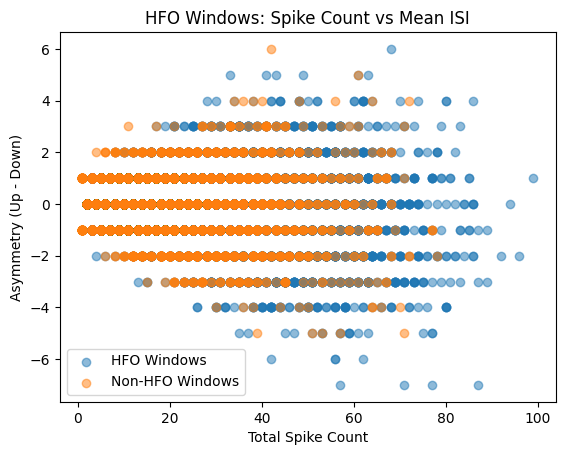

In [36]:
# Evaluate HFO windows
asymmetry_hfos = (hfo_up_counts - hfo_down_counts)
asymmetry_nonhfos = nonhfo_up_counts - nonhfo_down_counts

plt.scatter(total_hfo_counts,asymmetry_hfos , alpha=0.5, label='HFO Windows')
plt.scatter(total_nonhfo_counts,asymmetry_nonhfos, alpha=0.5, label='Non-HFO Windows')
plt.xlabel('Total Spike Count')
plt.ylabel('Asymmetry (Up - Down)')
plt.title('HFO Windows: Spike Count vs Mean ISI')
plt.legend()
plt.show()

In [ ]:
# Save the windowed 
# input data and ground truth to a file
save=False
if save:
    windowed_save=os.path.join(curr_dir,"windowed_data")
    os.makedirs(windowed_save, exist_ok=True)
    np.save(os.path.join(windowed_save, "filtered_windows.npy"), filtered_windows, allow_pickle=True)
    np.save(os.path.join(windowed_save, "windowed_input_data.npy"), windowed_input_data, allow_pickle=True)
    np.save(os.path.join(windowed_save,"windowed_gt.npy"), windowed_gt, allow_pickle=True)
    # Save the configuration to a JSON file
    with open(os.path.join(windowed_save, "config.json"), 'w') as f:
        json.dump(config, f, indent=4)